In [1]:
from pathlib import Path
import os
import sys 
path_dcf = str(Path(os.path.abspath('.')).resolve().parent)
sys.path.append(path_dcf)
from config import *
from algorithms.oneshot_dcf import DCF
from utils import *
from algorithms.utils_dilated_tubules import *
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import cv2
from torch_contour import CleanContours

/local/scratch/tmp/ipykernel_4169794/503967923.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


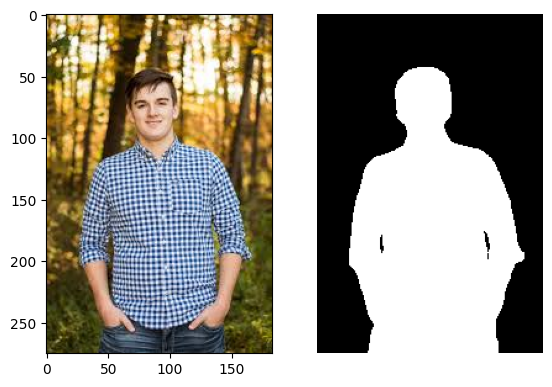

In [2]:
filename_support = "7.jpg"
height = 512
img = plt.imread(os.path.join(path_dcf,"images_test", filename_support)).astype(np.uint8)
gt =plt.imread(os.path.join(path_dcf,"images_test", "gt",filename_support.split('.')[-2]+".png")).astype(np.uint8)
f, axarr = plt.subplots(1,2)
plt.axis('off')
axarr[0].imshow(img)
axarr[1].imshow(gt, cmap='gray')
plt.show()

In [3]:
img_support = cv2.resize(img, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
gt_support = cv2.resize(gt, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
contours = np.squeeze(cv2.findContours(gt,1,3)[0][-1])/height
c = CleanContours()
contour_support = c.interpolate(contours, 100).clip(0, 1)
contour_support = torch.tensor(contour_support)[None, None]
tensor_support = torch.tensor(np.moveaxis(img_support,-1,0)[None])/255

## Choose a Slide from the dataset and a dilated tubule from the given slide

### Instanciate the object DCF one-shot

In [8]:
dcf = DCF(n_epochs=100,
        nb_augment=100,
        learning_rate=1e-1,
        clip=1e-4,
        sigma=1,
        isolines = None,
        exponential_decay=0.999,
        thresh=1e-2,
        isoline_weights=None
        )

### Show the Support dilated tubule and the annotation of the support

### Fit the one shot DCF

In [9]:
dcf.fit(tensor_support, contour_support)

100%|██████████| 100/100 [00:00<00:00, 151.22it/s]


### Predict on the query

In [10]:
filename_query = "83.jpg"
img_query = plt.imread(os.path.join(path_dcf,"images_test", filename_support)).astype(np.uint8)
img_query = cv2.resize(img_query, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
tensor_query = torch.tensor(np.moveaxis(img_query,-1,0)[None])/255


contour_init, mask = define_contour_init(
    height, center=[250, 250], axes=[250, 250], angle=0
)
shape = img_query.shape[:-1]
x = contour_init / np.array(shape)

### Change the initial contour to set up a number of nobes
nb_nodes = 100
c = CleanContours()
contour_init = c.interpolate(x, nb_nodes).clip(0, 1)

### predict
contour_init = torch.tensor(contour_init)[None, None]
print(contour_init)

contours, score, tots, energies = dcf.predict(tensor_query,
                                               contour_init)
# tots[tots == 0] = 1e100
# x = np.argmin(tots)
# contour_to_display = (np.expand_dims(contours[-1], 1)).astype(int)
# new_img = cv2.drawContours((((img_test/np.max(img_test))*255).astype(np.uint8)).copy(),
#                         [contour_to_display],
#                         0,
#                         color = 1,
#                         thickness=2)
# plt.imshow(new_img)
# plt.show()


tensor([[[[4.6484e-01, 1.9531e-03],
          [4.3318e-01, 4.4122e-03],
          [4.0174e-01, 7.4114e-03],
          [3.7156e-01, 1.3428e-02],
          [3.4267e-01, 2.2593e-02],
          [3.1383e-01, 3.1847e-02],
          [2.8612e-01, 4.3861e-02],
          [2.5901e-01, 5.7301e-02],
          [2.3248e-01, 7.2160e-02],
          [2.0635e-01, 8.7975e-02],
          [1.8173e-01, 1.0741e-01],
          [1.5856e-01, 1.3058e-01],
          [1.3654e-01, 1.5170e-01],
          [1.1334e-01, 1.7479e-01],
          [9.5484e-02, 2.0008e-01],
          [7.7227e-02, 2.2520e-01],
          [6.1169e-02, 2.5122e-01],
          [4.6875e-02, 2.7798e-01],
          [3.5002e-02, 3.0575e-01],
          [2.5494e-02, 3.3449e-01],
          [1.5733e-02, 3.6312e-01],
          [9.9110e-03, 3.9339e-01],
          [4.0549e-03, 4.2365e-01],
          [2.8829e-03, 4.5588e-01],
          [0.0000e+00, 4.8719e-01],
          [3.2648e-03, 5.1861e-01],
          [3.3148e-03, 5.5131e-01],
          [1.0024e-02, 5.812

ValueError: Tensor values should be in the range [0, 1]

### This cell save the images of the evolution of the contour over time in folder_images_paper

In [ ]:
import matplotlib
cmap = matplotlib.cm.get_cmap('cool')
 feedback a
colors = [cmap(u)[:-1] for u in np.linspace(0,1,dcf.n_epochs+1)]
colors = (np.array(colors)*255).astype(np.int32).tolist()

tots = []
imgs = []

for i, contour in enumerate(contours):

    contour_to_display = (np.expand_dims(contour, 1)).astype(int)
    
    new_img = cv2.drawContours((((img_test/np.max(img_test))*255).astype(np.uint8)).copy(),
                               [contour_to_display],
                               0,
                               color = colors[0],
                               thickness=3)
    plt.imsave(os.path.join('folder_images_paper',filename_img.split('.')[0]+'_'+str(i)+'.png'),new_img)


### This cell plot the evolution of the energies by (isoline, scale) over time

In [1]:
# ener = np.squeeze(energies.cpu().detach().numpy())                                                
# isolines = dcf.isolines.cpu().detach().numpy()
# for scale in range(5):
#     for index, isoline in enumerate(isolines):
#         plt.plot(np.arange(dcf.n_epochs),ener[:,scale,index],label = 'isoline '+str(isoline))
#     plt.title('evolution of the energies at scale: ' +str(scale+1))
#     plt.xlabel('step')
#     plt.ylabel('energie value')
#     plt.legend()
#     plt.show()


### This cell plot the repartition of the annotation over the different slides

In [ ]:
# annotations = pd.read_csv(os.path.join(path_annotations,'annotations.csv'), index_col=0)
# annotations = annotations.replace(['dilated_tubule','fake_tubule'], [1,0])
# dt_annotations = annotations[['image','term']].groupby('image').sum()
# dt_annotations.columns = ['number of dilated tubules']
# all_annotations = annotations[['image','term']].groupby('image').count()
# all_annotations.columns = ['number of annotations']

# dataset_stats = pd.concat([dt_annotations,all_annotations], axis = 1)
# dataset_stats['number of false dilated_tubule'] = dataset_stats['number of annotations'] - dataset_stats['number of dilated tubules']
# dataset_stats['image'] = dataset_stats.index
# dataset_stats = dataset_stats.reset_index(drop = True)
# dataset_stats['image'] = dataset_stats['image'].apply(lambda x: x.split('.')[0])
# dataset_stats
# # dataset_stats['image'] = dataset_stats.index.apply(lambda x : x.split('.')[0])

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1)

# plt.figure(figsize = (10,10))
# # plotting columns

# ax = sns.barplot(x=dataset_stats['image'],
#                  y=dataset_stats['number of annotations'],
#                  color = np.array([207,105,138])/255,
#                  label = 'n° of annotations')

# ax = sns.barplot(x=dataset_stats['image'],
#                  y=dataset_stats['number of dilated tubules'],
#                  color = np.array([137,44,80])/255,
#                  label = 'n° of dilated tubules')
 
# # renaming the axes
# ax.set_xlabel("Slide",fontsize = 20)
# ax.set_ylabel("N° of instances",fontsize = 20)
# plt.legend(fontsize = 20)

# # visualizing illustration
# plt.show()
